# 01 Exploratory Data Analysis (EDA)

This notebook explores the dataset and saves artifacts (plots/tables) into `artifacts/`.

In [24]:
%run ./00_shared_utils.ipynb

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
set_seeds()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Shared utilities loaded. Use build_full_pipeline(classifier) to create a text model pipeline.


In [25]:
DATA_PATH = Path('data/Tweets.csv') 
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

In [26]:
print(df.shape)
print(df.head())

(27481, 4)
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


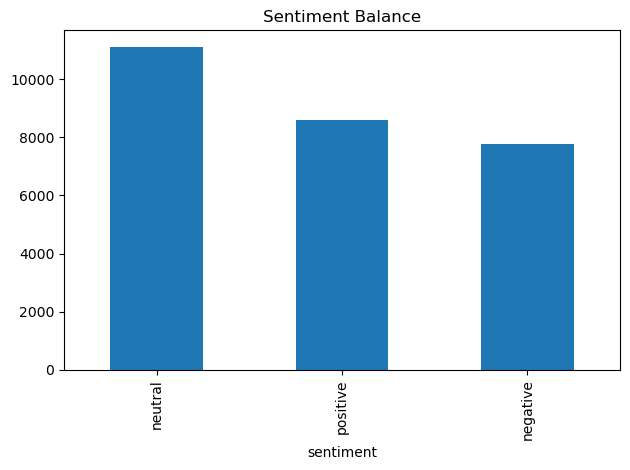

In [27]:
ax = df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Balance')
plt.tight_layout()
plt.savefig('artifacts/eda_sentiment_balance.png')
plt.show()

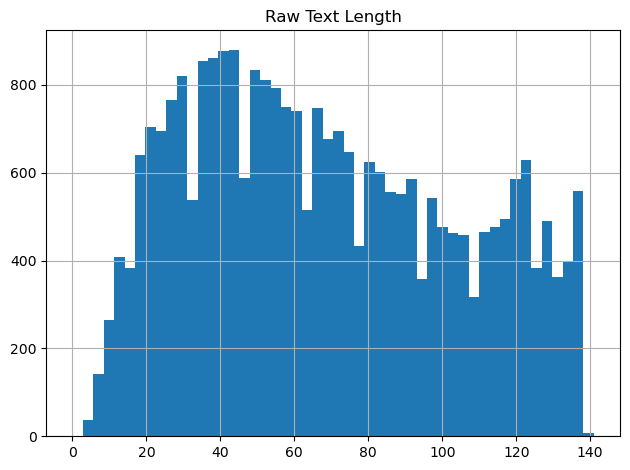

In [28]:
cleaned = CleaningTransformer().fit_transform(df[['text','selected_text']])
df['text_len_raw'] = df['text'].fillna('').str.len()
df['text_len_clean'] = cleaned['text_len']

plt.figure()
df['text_len_raw'].hist(bins=50)
plt.title('Raw Text Length')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_raw.png')
plt.show()

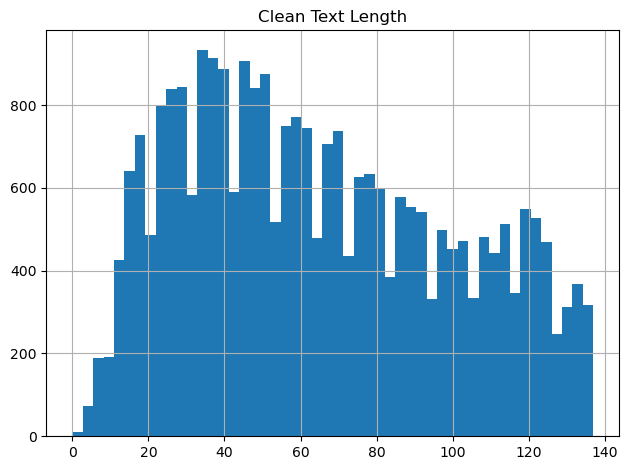

In [29]:
plt.figure()
df['text_len_clean'].hist(bins=50)
plt.title('Clean Text Length')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_clean.png')
plt.show()

In [30]:
feature_cols = ['text_len', 'url_count', 'mention_count', 'hashtag_count', 'has_emoji', 'keyword_overlap']
feature_profile = cleaned[feature_cols].copy()
feature_profile['sentiment'] = df['sentiment']
feature_summary = feature_profile.groupby('sentiment')[feature_cols].agg(['mean', 'median']).round(2)
print(feature_summary)
feature_summary.to_csv('artifacts/eda_feature_summary.csv')


          text_len        url_count        mention_count        hashtag_count  \
              mean median      mean median          mean median          mean   
sentiment                                                                       
negative     67.44   63.0      0.03    0.0           0.0    0.0          0.02   
neutral      61.75   55.0      0.06    0.0           0.0    0.0          0.02   
positive     66.95   63.0      0.05    0.0           0.0    0.0          0.02   

                 has_emoji        keyword_overlap         
          median      mean median            mean median  
sentiment                                                 
negative     0.0       0.0    0.0            0.89   1.00  
neutral      0.0       0.0    0.0            0.91   0.95  
positive     0.0       0.0    0.0            0.92   1.00  


In [31]:
df['selected_text_len'] = df['selected_text'].fillna('').str.len()
df['len_delta'] = df['text_len_clean'] - df['selected_text_len']
df['len_ratio'] = np.where(df['text_len_clean'] > 0, df['selected_text_len'] / df['text_len_clean'], np.nan)
df['len_ratio'] = df['len_ratio'].clip(0, 1)
len_summary = df.groupby('sentiment')[['text_len_clean', 'selected_text_len', 'len_delta', 'len_ratio']].agg(['mean', 'median']).round(2)
print(len_summary)
len_summary.to_csv('artifacts/eda_length_summary.csv')


          text_len_clean        selected_text_len        len_delta         \
                    mean median              mean median      mean median   
sentiment                                                                   
negative           67.44   63.0             19.97   12.0     47.47   43.0   
neutral            61.75   55.0             62.76   57.0     -1.01   -1.0   
positive           66.95   63.0             18.12   10.0     48.83   45.0   

          len_ratio         
               mean median  
sentiment                   
negative       0.35   0.21  
neutral        0.99   1.00  
positive       0.33   0.19  


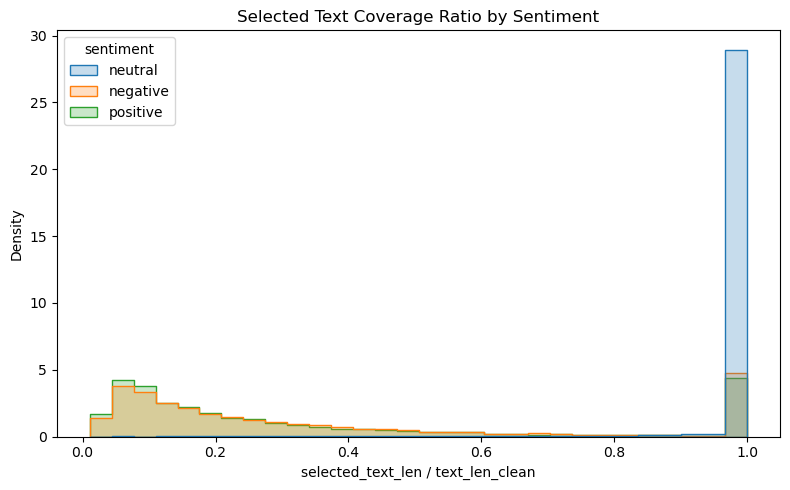

In [42]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='len_ratio', hue='sentiment', bins=30, element='step', stat='density', common_norm=False)
plt.title('Selected Text Coverage Ratio by Sentiment')
plt.xlabel('selected_text_len / text_len_clean')
plt.tight_layout()
plt.savefig('artifacts/eda_len_ratio_hist.png')
plt.show()


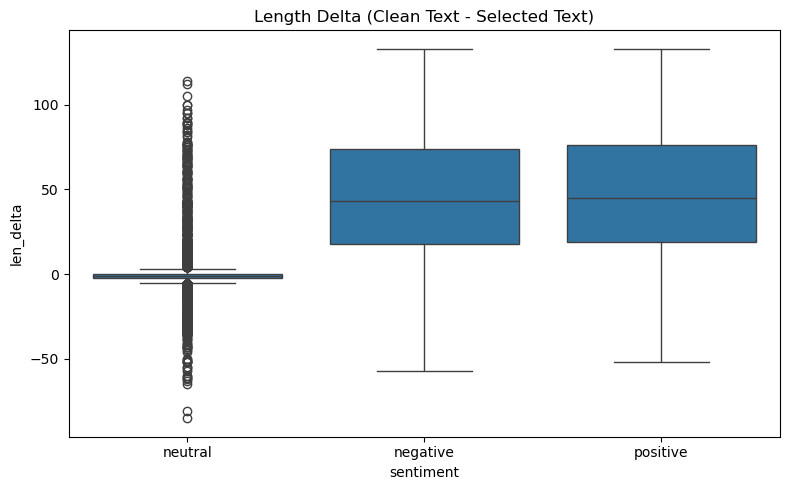

In [ ]:
    plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sentiment', y='len_delta')
plt.title('Length Delta (Clean Text - Selected Text)')
plt.tight_layout()
plt.savefig('artifacts/eda_len_delta_boxplot.png')
plt.show()

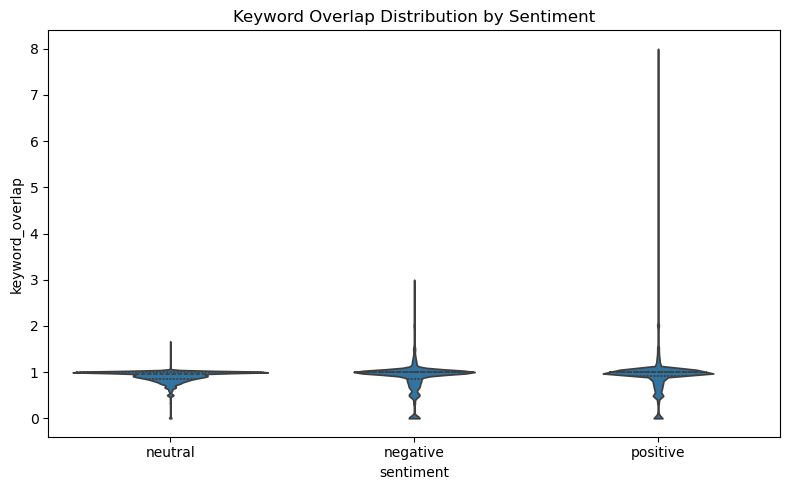

In [33]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=feature_profile, x='sentiment', y='keyword_overlap', inner='quartile', cut=0)
plt.title('Keyword Overlap Distribution by Sentiment')
plt.tight_layout()
plt.savefig('artifacts/eda_keyword_overlap_violin.png')
plt.show()


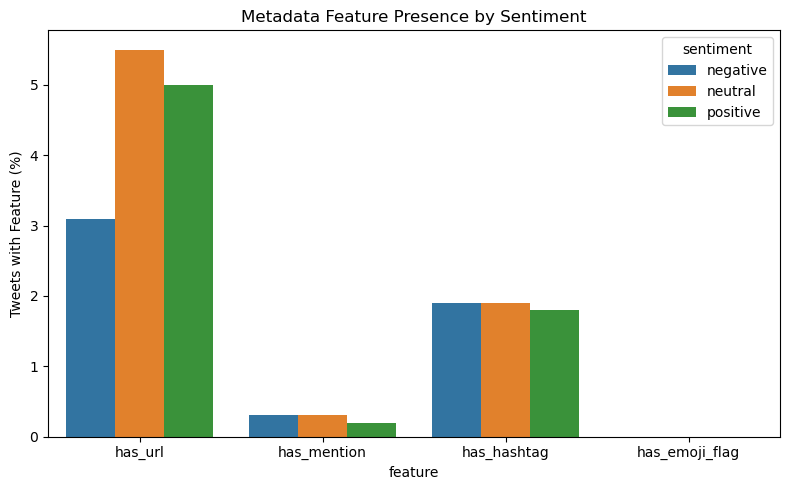

In [34]:
presence = feature_profile.copy()
presence['has_url'] = (presence['url_count'] > 0).astype(int)
presence['has_mention'] = (presence['mention_count'] > 0).astype(int)
presence['has_hashtag'] = (presence['hashtag_count'] > 0).astype(int)
presence['has_emoji_flag'] = presence['has_emoji']
presence_rates = presence.groupby('sentiment')[['has_url', 'has_mention', 'has_hashtag', 'has_emoji_flag']].mean().mul(100).round(1)
presence_melt = presence_rates.reset_index().melt(id_vars='sentiment', var_name='feature', value_name='percent')
plt.figure(figsize=(8, 5))
sns.barplot(data=presence_melt, x='feature', y='percent', hue='sentiment')
plt.ylabel('Tweets with Feature (%)')
plt.title('Metadata Feature Presence by Sentiment')
plt.tight_layout()
plt.savefig('artifacts/eda_feature_presence.png')
plt.show()
presence_rates.to_csv('artifacts/eda_feature_presence_rates.csv')


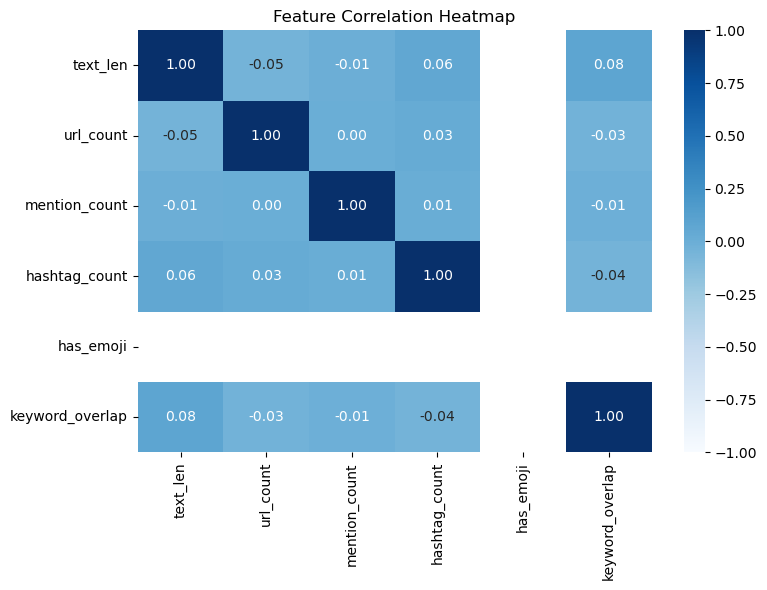

In [35]:
corr = feature_profile[feature_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('artifacts/eda_feature_corr_heatmap.png')
plt.show()


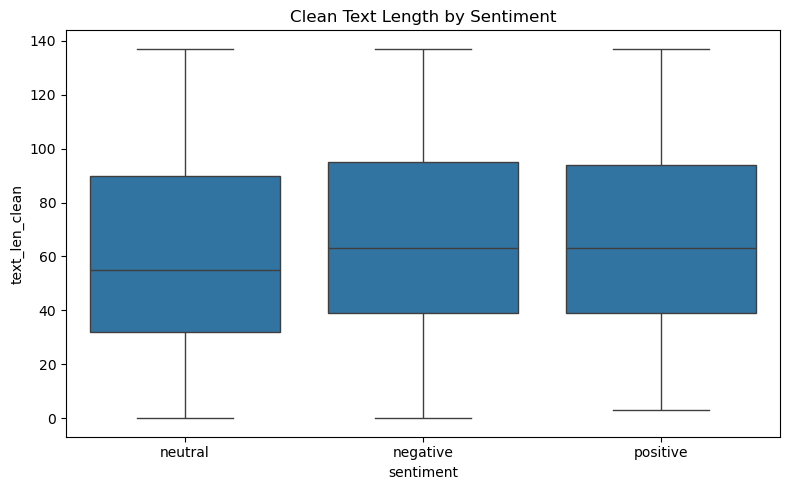

In [36]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sentiment', y='text_len_clean')
plt.title('Clean Text Length by Sentiment')
plt.tight_layout()
plt.savefig('artifacts/eda_text_len_boxplot.png')
plt.show()


In [37]:
from collections import Counter
top_k_bigrams = 10
bigram_terms = {}
for sentiment, texts in cleaned['text_clean'].groupby(df['sentiment']):
    counter = Counter()
    for txt in texts.dropna():
        tokens = txt.split()
        counter.update(zip(tokens, tokens[1:]))
    records = counter.most_common(top_k_bigrams)
    bigram_terms[sentiment] = [f"'{w1} {w2}' ({freq})" for (w1, w2), freq in records]
max_len_bg = max(len(v) for v in bigram_terms.values()) if bigram_terms else 0
if max_len_bg:
    for sent, values in bigram_terms.items():
        if len(values) < max_len_bg:
            values.extend([''] * (max_len_bg - len(values)))
    bigram_df = pd.DataFrame(bigram_terms)
    bigram_df.index = pd.Index(range(1, max_len_bg + 1), name='rank')
    print(bigram_df)
    bigram_df.to_csv('artifacts/eda_top_bigrams.csv')
else:
    print('No bigrams available for summary.')


              negative           neutral              positive
rank                                                          
1          'i m' (880)       'i m' (770)           'i m' (565)
2         'it s' (371)      'it s' (467)        'i love' (403)
3        'don t' (338)     'don t' (351)          'it s' (357)
4        'can t' (331)    'in the' (336)      'mother s' (331)
5       'i have' (294)  'going to' (307)        'have a' (260)
6        'i can' (245)    'i have' (295)  'happy mother' (259)
7       'in the' (243)     'i can' (273)         's day' (251)
8     'going to' (235)     'but i' (267)        'in the' (239)
9       'i miss' (229)     'can t' (262)       'for the' (229)
10       'and i' (228)    'to the' (227)        'day to' (213)


In [38]:
from collections import Counter
top_k = 10
top_terms = {}
for sentiment, texts in cleaned['text_clean'].groupby(df['sentiment']):
    counter = Counter()
    for txt in texts.dropna():
        counter.update(txt.split())
    records = counter.most_common(top_k)
    top_terms[sentiment] = [f"'{tok}' ({freq})" for tok, freq in records]
max_len = max(len(v) for v in top_terms.values()) if top_terms else 0
if max_len:
    for sent, values in top_terms.items():
        if len(values) < max_len:
            values.extend([''] * (max_len - len(values)))
    token_df = pd.DataFrame(top_terms)
    token_df.index = pd.Index(range(1, max_len + 1), name='rank')
    print(token_df)
    token_df.to_csv('artifacts/eda_top_tokens.csv')
else:
    print('No tokens available for summary.')


          negative       neutral      positive
rank                                          
1       'i' (5621)    'i' (6071)    'i' (4549)
2      'to' (2877)   'to' (4121)  'the' (2997)
3     'the' (2446)  'the' (3533)   'to' (2962)
4      'my' (2019)    'a' (2528)    'a' (2411)
5       'a' (1817)   'my' (1998)  'you' (2007)
6     'and' (1554)  'and' (1839)  'and' (1656)
7      'it' (1399)   'it' (1770)   'my' (1483)
8      'is' (1331)  'you' (1749)   'it' (1457)
9       't' (1262)   'in' (1575)    's' (1369)
10     'in' (1099)   'is' (1476)  'for' (1331)


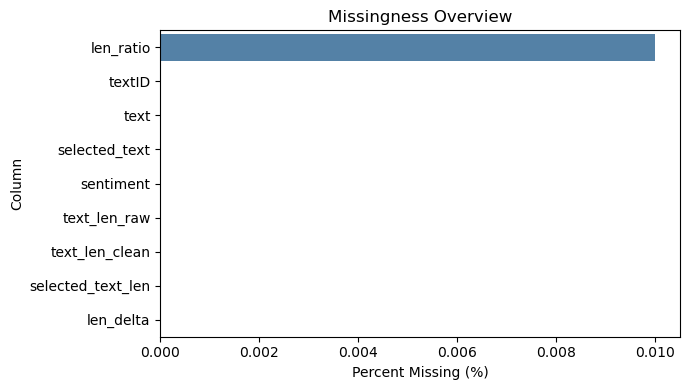

In [39]:
missing_pct = df.isna().mean().mul(100).round(2).sort_values(ascending=False)
missing_df = missing_pct.reset_index()
missing_df.columns = ['column', 'percent_missing']
plt.figure(figsize=(7, 4))
sns.barplot(data=missing_df, x='percent_missing', y='column', color='steelblue')
plt.xlabel('Percent Missing (%)')
plt.ylabel('Column')
plt.title('Missingness Overview')
plt.tight_layout()
plt.savefig('artifacts/eda_missingness.png')
plt.show()
missing_df.to_csv('artifacts/eda_missingness.csv', index=False)


In [40]:
dup_by_id = df['textID'].duplicated().sum() if 'textID' in df.columns else 0
dup_by_text = df['text'].duplicated().sum()
na_counts = df.isna().sum()

summary = {
    'rows': int(df.shape[0]),
    'cols': int(df.shape[1]),
    'dup_by_id': int(dup_by_id),
    'dup_by_text': int(dup_by_text),
    'na_counts': na_counts.to_dict()
}
print(json.dumps(summary, indent=2))

with open('artifacts/eda_summary.json','w') as f:
    json.dump(summary, f, indent=2)

df.sample(20).to_csv('artifacts/eda_sample.csv', index=False)
print("EDA artifacts saved under artifacts/.")

{
  "rows": 27481,
  "cols": 9,
  "dup_by_id": 0,
  "dup_by_text": 0,
  "na_counts": {
    "textID": 0,
    "text": 1,
    "selected_text": 1,
    "sentiment": 0,
    "text_len_raw": 0,
    "text_len_clean": 0,
    "selected_text_len": 0,
    "len_delta": 0,
    "len_ratio": 4
  }
}
EDA artifacts saved under artifacts/.
